In [6]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import random
import os

# Define class folders and labels
class_folders = {
    "arritmia": 0,
    "block": 1,
    "fibrilation": 2,
    "normal": 3
}

files_per_class = 200  # Change this number as needed

dfs = []
for folder, label in class_folders.items():
    files = glob.glob(f"data/{folder}/*.parquet.gzip")
    print(f"{folder}: {len(files)} files found")
    # Sample a subset of files to avoid loading everything
    if len(files) > files_per_class:
        files = random.sample(files, files_per_class)
    for f in files:
        try:
            df = pd.read_parquet(f, engine="fastparquet")
        except Exception as e:
            print(f"falló leer {f}, Error: {e}")
            continue
        df = df.copy()
        df['ecg_id'] = os.path.basename(f)  # Add filename as ECG identifier
        df['label'] = label
        dfs.append(df)

# Combine all data (stack all rows, each with ecg_id)
all_data = pd.concat(dfs, ignore_index=True)

# Now you can distinguish each ECG by the 'ecg_id' column
print('Unique ECGs loaded:', all_data['ecg_id'].nunique())

# Find the minimum class count for balancing (by unique ecg_id)
min_count = all_data.groupby('label')['ecg_id'].nunique().min()

# Sample min_count ecg_id per class for balancing
balanced_ecgs = []
for label in all_data['label'].unique():
    ecg_ids = all_data[all_data['label'] == label]['ecg_id'].unique()
    sampled_ids = random.sample(list(ecg_ids), min_count)
    balanced_ecgs.append(all_data[(all_data['label'] == label) & (all_data['ecg_id'].isin(sampled_ids))])
balanced = pd.concat(balanced_ecgs, ignore_index=True)

# Split into train/test by ecg_id to avoid leakage
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(balanced['ecg_id'].unique(), test_size=0.2, random_state=42, stratify=balanced.drop_duplicates('ecg_id')['label'])
train_df = balanced[balanced['ecg_id'].isin(train_ids)]
test_df = balanced[balanced['ecg_id'].isin(test_ids)]

print("Train class distribution:\n", train_df.drop_duplicates('ecg_id')['label'].value_counts())
print("Test class distribution:\n", test_df.drop_duplicates('ecg_id')['label'].value_counts())

arritmia: 7645 files found
block: 2329 files found
block: 2329 files found
fibrilation: 1970 files found
fibrilation: 1970 files found
normal: 7368 files found
normal: 7368 files found
Unique ECGs loaded: 800
Unique ECGs loaded: 800
Train class distribution:
 label
0    160
1    160
2    160
3    160
Name: count, dtype: int64
Test class distribution:
 label
0    40
1    40
2    40
3    40
Name: count, dtype: int64
Train class distribution:
 label
0    160
1    160
2    160
3    160
Name: count, dtype: int64
Test class distribution:
 label
0    40
1    40
2    40
3    40
Name: count, dtype: int64


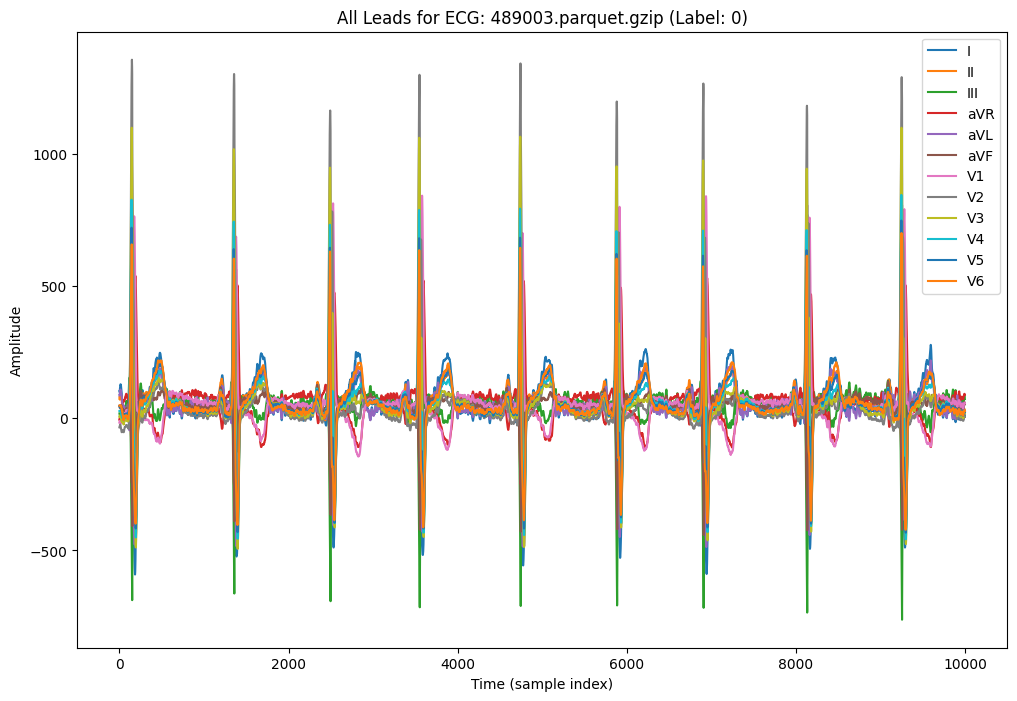

In [7]:
import matplotlib.pyplot as plt

# Plot all leads for the first ECG (by ecg_id)
first_ecg_id = all_data['ecg_id'].iloc[0]
first_ecg = all_data[all_data['ecg_id'] == first_ecg_id]

leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
plt.figure(figsize=(12, 8))
for lead in leads:
    plt.plot(first_ecg.index, first_ecg[lead], label=lead)
plt.title(f"All Leads for ECG: {first_ecg_id} (Label: {first_ecg['label'].iloc[0]})")
plt.xlabel("Time (sample index)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()